In [183]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [184]:
CONSTANTS = {
    'dt': 0.01,               
    'mass': 280.0,            # kg 
    'wheel_radius': 0.254,    # m 
    'wheel_inertia': 0.35,    # kg-m^2 
    'cg_height': 0.28,        # m
    'wheelbase': 1.53,        # m 
    'drag_coeff': 0.75,
    'gear_ratio': 11.5,
    'max_torque': 62.0,       # Nm 
    'max_brake_torque': 550.0,# Nm 
    'peak_slip_angle': 0.12,  # 
    'base_friction': 1.6,     # 
    'drivetrain_damping': 0.8 #
}

In [185]:
def get_driver_input(t, current_slip, target_slip, driver_style):
    """
    Balanced tweak:
      - increase 10-15% via more frequent moderate pushes + small hold near 8-12%
      - increase 25%+ via slightly stronger (still rare) bursts
      - conservative: keep realism and avoid flood of extremes
    """
    phase = int(t * 10) % 150 / 10.0

    kp = 1.0
    base_tps = 0.0
    run_bias = np.random.normal(0.0, 0.02)

    # LAUNCH (0-3s)
    if phase < 3.0:
        base_tps = 0.96
        kp = 0.28 if driver_style == "aggressive" else 0.36
        if np.random.rand() < 0.10:
            base_tps = np.clip(base_tps + np.random.uniform(0.08, 0.18), 0, 1)
        if np.random.rand() < 0.01:
            base_tps = 1.0

    # TECHNICAL (3-10s) - heavier focus here to grow 10-15%
    elif phase < 10.0:
        base_tps = 0.55 + 0.45 * np.sin(t * 6.0)
        kp = 1.00 if driver_style != "aggressive" else 0.82
        # Increase frequency and slightly raise lower bound -> more 0.10-0.15
        if np.random.rand() < 0.48:   # increased from ~0.34 -> 0.48
            base_tps = np.clip(base_tps + np.random.uniform(0.12, 0.26), 0, 1)

    # SHORT STRAIGHT (10-12s) - maintain recovery but still allow pushes
    elif phase < 12.0:
        base_tps = 0.95
        kp = 1.40 if driver_style != "aggressive" else 0.95
        if np.random.rand() < 0.30:
            base_tps = np.clip(base_tps + np.random.uniform(0.08, 0.22), 0, 1)

    else:
        base_tps = 0.0
        kp = 0.0

    # Feedback correction
    error = current_slip - target_slip
    if driver_style == "aggressive" and error > 0:
        correction = error * kp * 0.45
    else:
        correction = error * kp
    final_tps = base_tps - correction

    # BURSTS: slightly stronger and marginally more frequent to reach 25%+ target
    if np.random.rand() < 0.012:            # 1.2% chance (was 0.8%)
        burst_strength = np.random.uniform(0.12, 0.32)  # slightly stronger bursts
        final_tps = np.clip(final_tps + burst_strength, 0.0, 1.0)

    # If in launch phase, allow occasional stronger boost
    if phase < 3.0 and np.random.rand() < 0.04:
        final_tps = np.clip(final_tps + np.random.uniform(0.12, 0.28), 0.0, 1.0)

    # Gentle *hold/assist* for near-threshold slips: nudge samples in 0.08-0.12 up into 0.10-0.15
    # This is small and conservative (avoids artificial behavior away from the control band)
    if 0.08 <= current_slip <= 0.12 and np.random.rand() < 0.65:
        # tiny assist tuned to push into 10-15% without becoming full throttle
        final_tps = np.clip(final_tps + np.random.uniform(0.03, 0.09), 0.0, 1.0)

    # If slip is already extremely high (>0.50), trim to avoid long tails (prevent flood)
    if current_slip > 0.50:
        reduction = 0.50 if driver_style == "aggressive" else 0.65
        final_tps = np.clip(final_tps * (1.0 - reduction), 0.0, 1.0)

    # human foot noise & run bias
    foot_noise = np.random.normal(0, 0.032)
    final_tps = np.clip(final_tps + foot_noise + run_bias, 0.0, 1.0)

    steer = np.sin(t * 1.0) * 0.2 + np.random.normal(0, 0.01)
    return final_tps, steer


In [186]:
# model drivetrain features
def calculate_drivetrain(tps, wheel_omega, const):
    engine_torque = tps * const['max_torque']
    net_torque = engine_torque * const['gear_ratio']
    rpm = rpm = wheel_omega * const['gear_ratio'] * 9.54

    return net_torque, rpm

In [187]:
# calculates normal load based on accel_x
def calculate_normal_load(ax, const):
    static_weight = (const['mass'] * 9.81) / 2 
    transfer = (const['mass'] * ax * const['cg_height']) / const['wheelbase']
    normal_load = static_weight + transfer # Rear load increases with Accel
    return max(normal_load, 50.0)

In [188]:
# Pacejka Magic
def magic_formula(slip, load, steer_angle, peak_slip, current_mu):
    steer_penalty = max(0.6, 1.0 - abs(steer_angle) * 1.0)
    mu_peak = current_mu * steer_penalty
    
    abs_slip = abs(slip)
    
    if abs_slip < peak_slip:
        ratio = abs_slip / peak_slip
        force = load * mu_peak * np.sin(ratio * 1.57)
    else:
        # 98% saturation (stable slide)
        force = load * mu_peak * 0.98
        
    return force

In [189]:
def generate_dataset():
    c = CONSTANTS
    
    vx = 5.0 
    omega = vx / c['wheel_radius']
    temp = 30.0
    ax_prev = 0.0
    last_slip = 0.0
    
    data_rows = []
    
    # We will simulate 3 different "Drivers" to get full coverage
    # 1. "Pro" -> Targets 0.12 (Optimal)
    # 2. "Rookie" -> Targets 0.18 (A bit loose)
    # 3. "Drifter" -> Targets 0.25 (Very loose)
    
    current_target = 0.15
    driver_type = "normal"
    
    for i in range(40000): # 400 seconds
        t = i * c['dt']
        
        # Switch Driver Style every 25s lap
        if i % 2500 == 0:
            rand = np.random.rand()
            if rand < 0.33:
                current_target = np.random.uniform(0.10, 0.14) # Pro
                driver_type = "normal"
            elif rand < 0.66:
                current_target = np.random.uniform(0.15, 0.20) # Rookie
                driver_type = "aggressive"
            else:
                current_target = np.random.uniform(0.20, 0.30) # Drifter
                driver_type = "aggressive"
        
        # 1. Driver Input
        tps, steer = get_driver_input(t, last_slip, current_target, driver_type)
        
        # 2. Physics & Integration
        engine_torque = tps * c['max_torque']
        net_torque = engine_torque * c['gear_ratio']
        rpm = omega * c['gear_ratio'] * 9.54
        
        static_weight = (c['mass'] * 9.81) / 2 
        transfer = (c['mass'] * ax_prev * c['cg_height']) / c['wheelbase']
        fz = max(static_weight + transfer, 50.0)
        
        denom = max(vx, 0.5) 
        raw_slip = (omega * c['wheel_radius'] - vx) / denom
        true_slip = np.clip(max(0.0, raw_slip), 0.0, 1.0)
        last_slip = true_slip 
        
        fx = magic_formula(true_slip, fz, steer, c['peak_slip_angle'], c['base_friction'])
        
        drag = c['drag_coeff'] * vx**2
        ax = (fx - drag) / c['mass']
        vx += ax * c['dt']
        
        damping = omega * c['drivetrain_damping']
        alpha = (net_torque - fx * c['wheel_radius'] - damping) / c['wheel_inertia']
        omega += alpha * c['dt']
        
        vx = max(vx, 0.0)
        omega = max(omega, 0.0)
        ax_prev = ax
        
        front_wheel_speed_mps = vx + np.random.normal(0, 0.1)
        
        row = {
            'wheel_omega': omega + np.random.normal(0, 0.5), 
            'accel_x': ax + np.random.normal(0, 0.2),        
            'tps': tps,                                      
            'engine_rpm': rpm + np.random.normal(0, 50),     
            'steering_angle': steer,                         
            'yaw_rate': (vx * np.tan(steer) / c['wheelbase']) + np.random.normal(0, 0.1), 
            'tire_temp': temp,    
            'front_wheel_speed': front_wheel_speed_mps,      
            'TARGET_slip_ratio': true_slip 
        }
        data_rows.append(row)

    return pd.DataFrame(data_rows)

------------------------------
SLIP FILLER REPORT
------------------------------
0-5%:   37.1%
5-10%:  23.3%
10-15%: 10.3% (GOAL: >15%)
15-25%: 13.5% (GOAL: >10%)
25%+:   15.7%
------------------------------


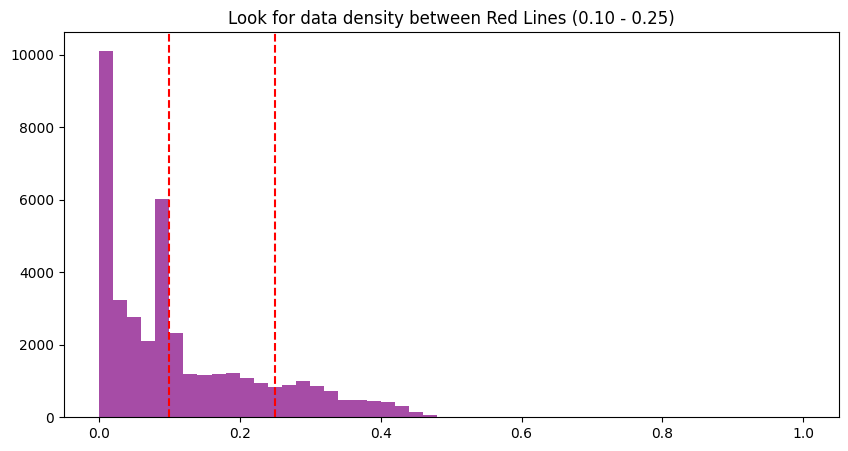

In [190]:
df = generate_dataset()

# Validation
print("-" * 30)
print("SLIP FILLER REPORT")
print("-" * 30)
# Buckets
s = df['TARGET_slip_ratio']
b1 = len(s[(s >= 0.00) & (s < 0.05)])
b2 = len(s[(s >= 0.05) & (s < 0.10)])
b3 = len(s[(s >= 0.10) & (s < 0.15)]) # The target zone
b4 = len(s[(s >= 0.15) & (s < 0.25)]) # The extended target
b5 = len(s[(s >= 0.25)])

total = len(df)
print(f"0-5%:   {b1/total*100:.1f}%")
print(f"5-10%:  {b2/total*100:.1f}%")
print(f"10-15%: {b3/total*100:.1f}% (GOAL: >15%)")
print(f"15-25%: {b4/total*100:.1f}% (GOAL: >10%)")
print(f"25%+:   {b5/total*100:.1f}%")
print("-" * 30)

# Histogram
plt.figure(figsize=(10,5))
plt.hist(df['TARGET_slip_ratio'], bins=50, color='purple', alpha=0.7)
plt.axvline(0.10, color='red', linestyle='--')
plt.axvline(0.25, color='red', linestyle='--')
plt.title("Look for data density between Red Lines (0.10 - 0.25)")
plt.show()

df.to_csv('fsae_synthetic_slip_filler.csv', index=False)